In [1]:
%matplotlib inline
import Euclid
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from astropy.table import Table
from astropy import units as u
from astropy.units import photometric

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)

## Setup environment

In [3]:
%elogin

In [4]:
%erun Phosphoros

In [5]:
from PhzCLI.PlotSpecZComparison import SpeczPhotozPlot, displayHistogram, compute_stats

## Read the join catalog PHZ+MER+TU

In [6]:
t = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Prod/PHZ_MER.fits')

In [7]:
len(t)

324999

## Filter out objects with SNR <= 10

In [8]:
snr = t['FLUX_VIS_APER'] / t['FLUXERR_VIS_APER'] > 10

In [9]:
t = t[snr]

In [10]:
len(t)

306215

## Compute Magnitude AB

In [11]:
t['FLUX_VIS_APER'].unit = u.Jy
t['MAG_VIS_AB'] = t['FLUX_VIS_APER'].to(u.mag(photometric.AB))

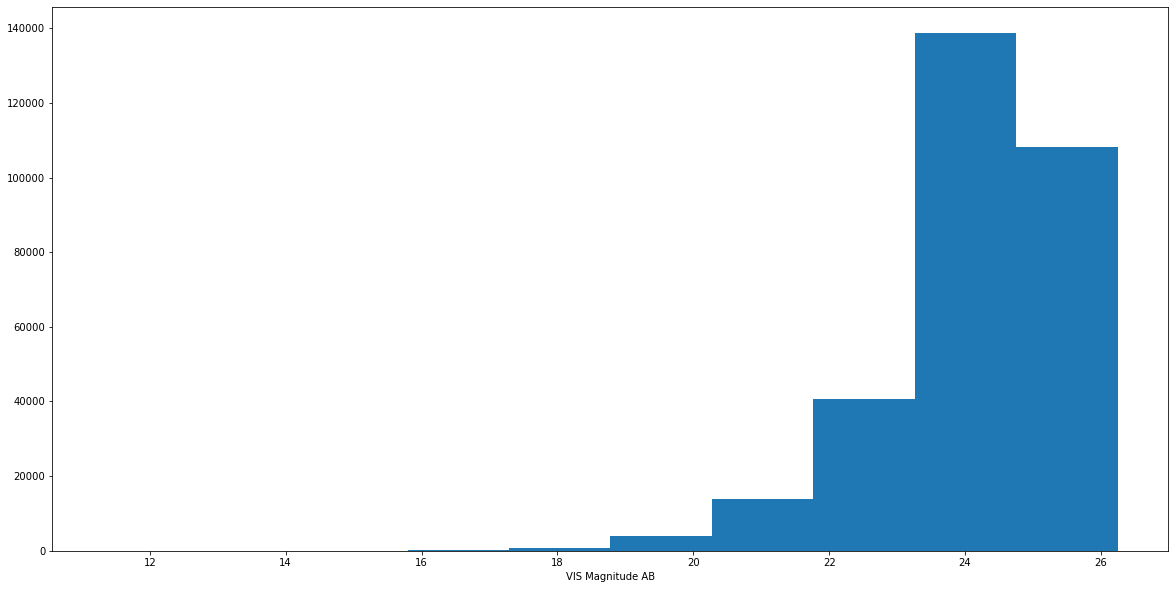

In [12]:
plt.figure()
plt.hist(t['MAG_VIS_AB'])
plt.xlabel('VIS Magnitude AB')
plt.show()

## Apply cut

In [15]:
mag_vis = t['MAG_VIS_AB'] < 24.5

In [16]:
t = t[mag_vis]
len(t)

103789

## Compute statistics

In [17]:
data, mean, median, sigma, mad, outliersPercent,sigmaNoOutliers, meanNoOutliers = compute_stats(t['Z_OBS'], t['REDSHIFT_MEDIAN'])

--> Mean                :  0.016201243
--> Median              :  0.0072827456
--> Sigma               :  0.077700496
--> Mad                 :  0.03678373
--> Outliers            :  6.056518513522628 %
--> Sigma (no outliers) :  0.03415254


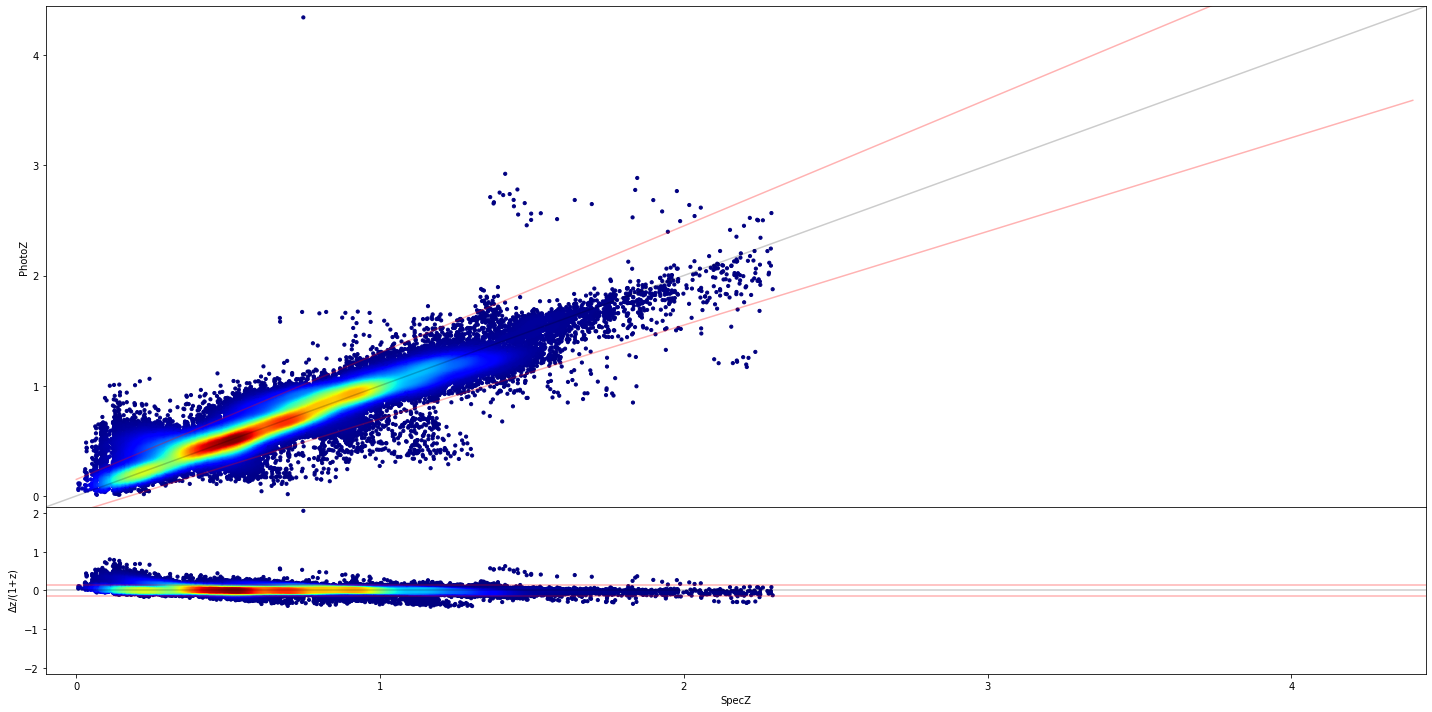

In [18]:
SpeczPhotozPlot(t['OBJECT_ID'], t['Z_OBS'], t['REDSHIFT_MEDIAN'], data)

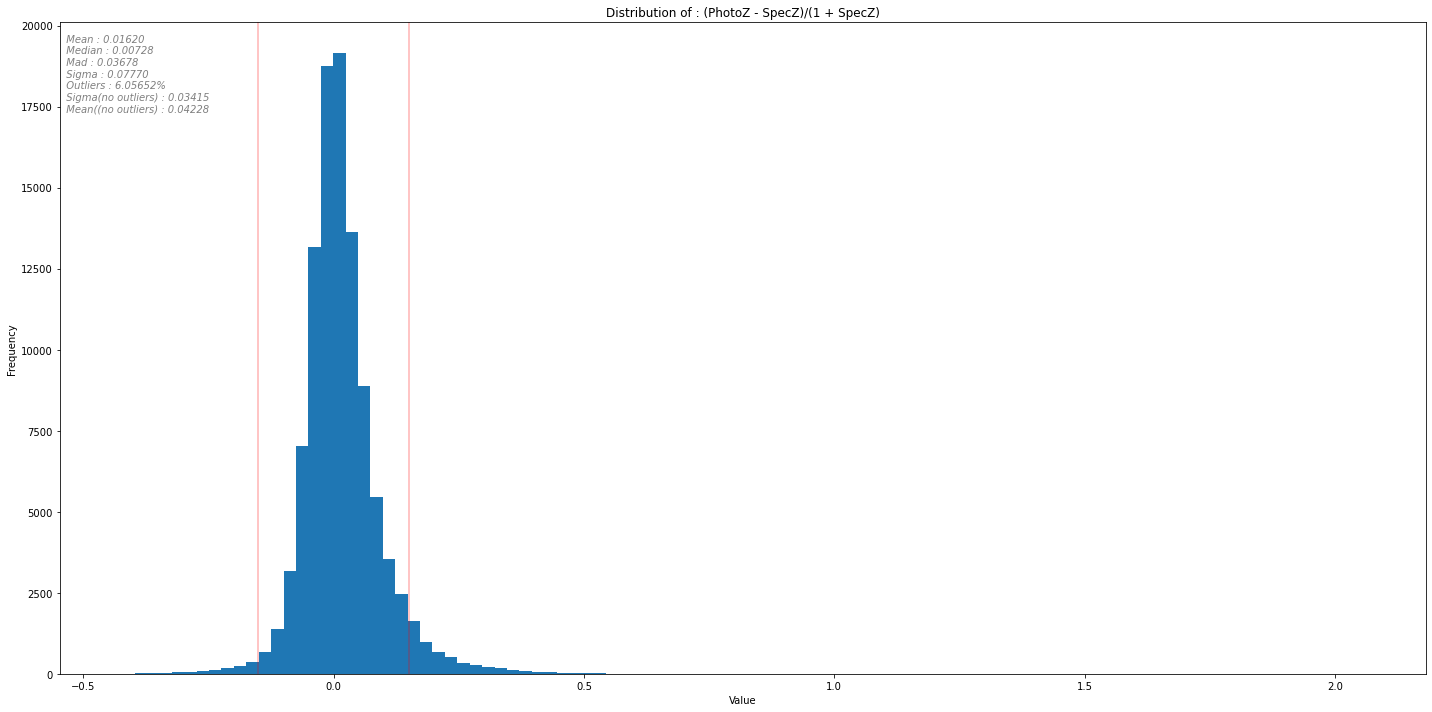

In [19]:
_ = displayHistogram(data, mean, median, mad, sigma, outliersPercent, sigmaNoOutliers, meanNoOutliers, figsize=(20, 10))

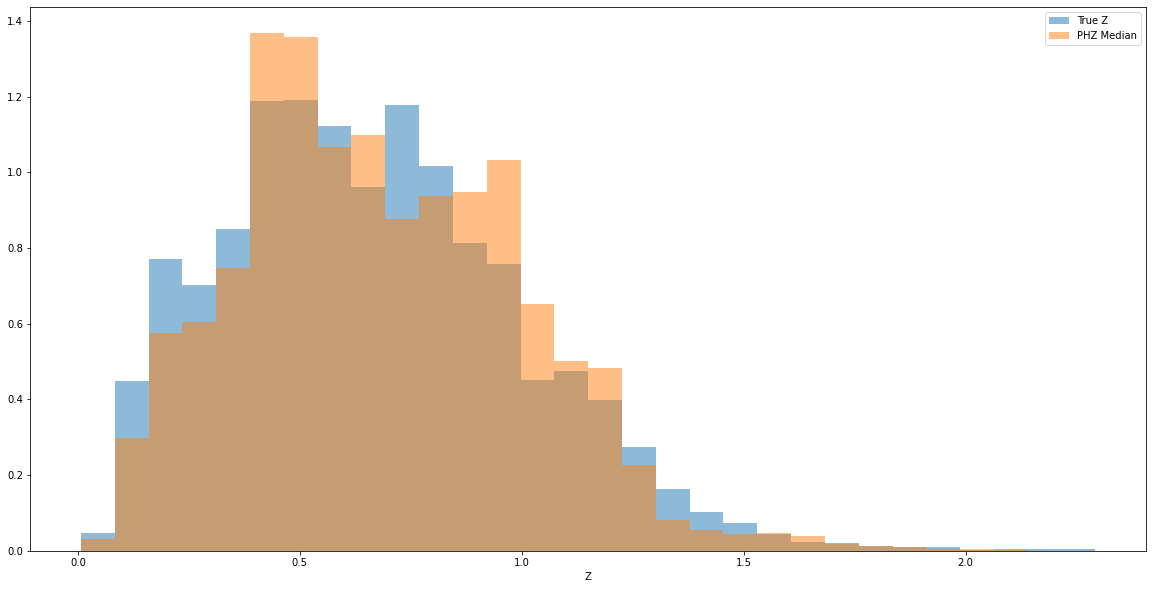

In [20]:
plt.figure()
bins = plt.hist(t['Z_OBS'], bins=30, alpha=0.5, density=True, label='True Z')
plt.hist(t['REDSHIFT_MEDIAN'], bins=bins[1], alpha=0.5, density=True, label='PHZ Median')
plt.xlabel('Z')
plt.legend()
plt.show()

## Box plot

In [21]:
edges = np.histogram_bin_edges(t['MAG_VIS_AB'], bins=10)
centers = (edges[1:] + edges[:-1])/2
bins = np.digitize(t['MAG_VIS_AB'], bins=edges)

In [22]:
err = t['REDSHIFT_MEDIAN'] - t['Z_OBS']
median_err = []
q1_err = []
q3_err = []
data = []
err_centers = []
for b in np.arange(1, 1+len(centers)):
    err_data = err[bins==b]
    if len(err_data) == 0:
        continue
    data.append(err_data)
    err_centers.append(centers[b-1])
    q1, m, q3 = np.quantile(err_data, [0.25, 0.5, 0.75])
    q1_err.append(q1)
    median_err.append(m)
    q3_err.append(q3)
q1_err = np.array(q1_err)
median_err = np.array(median_err)
q3_err = np.array(q3_err)

/home/aalvarez/miniconda3/envs/phz/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


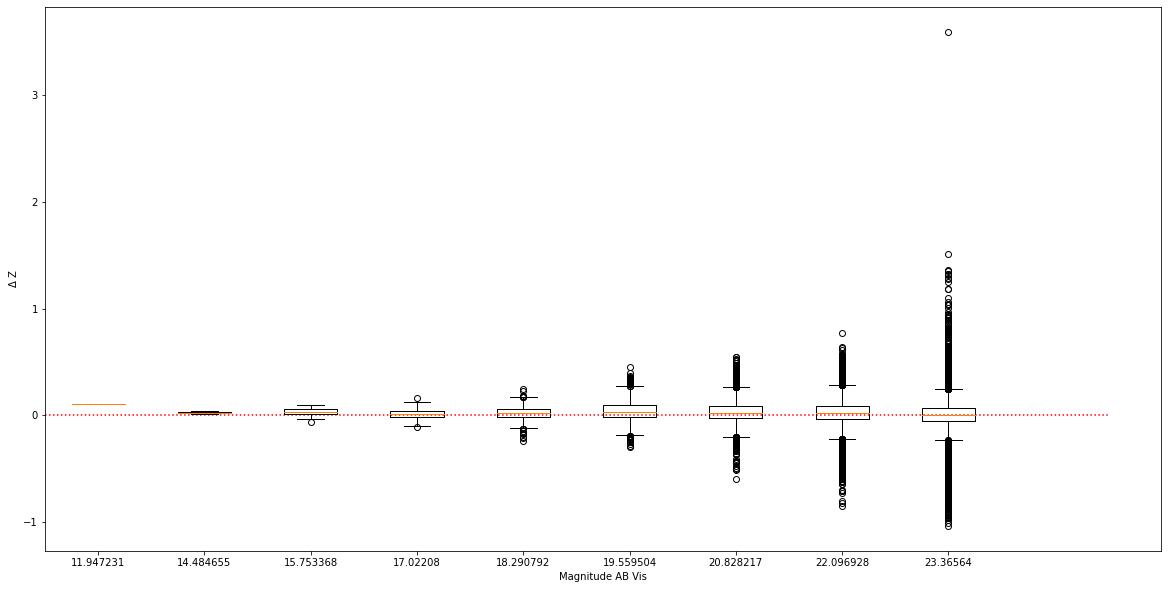

In [23]:
plt.figure(figsize=(20,10))
plt.boxplot(data, labels=err_centers)
plt.hlines(0, 0.5, 10.5, linestyle=':', color='r')
plt.xlabel('Magnitude AB Vis')
plt.ylabel('$\Delta$ Z')
plt.show()